#**MTA project 1** 


---



##**Introduction**:

A small company that sells merch across the U.S wants to place five new trucks that sell souvenirs for the tourists in summer in front of the MTA subway stations, the company wants to optimize the profits by placing the three trucks in the stations that are on high demand in the summer. Therefore, they want a data analysis of the MTA turnstile dataset to find the best time slots and locations to place the trucks in New York.

##**Dataset attributes**:


*  **C/A** : Control Area
*  **Unit** : Remote Unit for a station
*  **SCP** : Subunit Channel Position represents an specific address for a device 
*  **Station** : Represents the station name the device is located at
*  **Date** : Represents the date
*  **Time** : Represents the time (hh:mm:ss) for a scheduled audit event
*  **Desc** : Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
*  **Entries** : The comulative entry register value for a device
*  **Exits** : The cumulative exit register value for a device



---




In [45]:
#@title
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
from pandas.api.types import CategoricalDtype
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##Loading the dataset

The data that I will use is for the summer of 2021. So, I will extract the data from the date **19 June 2021 until 22 September 2021** which are the dates of the start and finish for summer in the U.S.

In [46]:
#to initialize the number of weeks
Number_of_weeks = 14

#initialise the starting date for the summer 19 June 2021
start_date = filedate = pd.Timestamp('2021-06-19 00:00:00')
 
#the MTA dataset URL using format to change the date
MTA_URL = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

filelist = []

for numfiles in range (Number_of_weeks):

    # create the appropriate filename for the week
    filedate_str = str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2)
    

    # read the file and append it to the list of files to be concacated
    df = pd.read_csv( MTA_URL.format(filedate_str))
    filelist.append(df)

    # advance to the next week
    filedate += pd.Timedelta(days=7)

MTA_df = pd.concat(filelist, axis=0, ignore_index=True)

In [47]:
MTA_df.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
2932684,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,5554,643
2932685,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,5554,643
2932686,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,5554,643
2932687,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,17:00:00,REGULAR,5554,643
2932688,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,21:00:00,REGULAR,5554,644


## Renaming the columns

In [48]:
MTA_df.columns.values

array(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE',
       'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype=object)

Removing the space after the EXITS column

In [49]:
MTA_df.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)
MTA_df.tail(29)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
2932660,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/13/2021,05:00:00,REGULAR,5554,643
2932661,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/13/2021,09:00:00,REGULAR,5554,643
2932662,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/13/2021,13:00:00,REGULAR,5554,643
2932663,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/13/2021,17:00:00,REGULAR,5554,643
2932664,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/13/2021,21:00:00,REGULAR,5554,643
2932665,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/14/2021,01:00:00,REGULAR,5554,643
2932666,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/14/2021,05:00:00,REGULAR,5554,643
2932667,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/14/2021,09:00:00,REGULAR,5554,643
2932668,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/14/2021,13:00:00,REGULAR,5554,643
2932669,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/14/2021,17:00:00,REGULAR,5554,643




---


## Removing duplicates

we need to group by each unique turnstile and the datetime to count their ENTRIES. if the ENTRIES count > 1 then we need to get rid of the duplicated ones.

In [50]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", is unique
(MTA_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE",'TIME'])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(10)

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
2909626,S101,R070,00-00-02,ST. GEORGE,09/12/2021,20:00:00,2
1261029,N335,R158,01-00-03,KEW GARDENS,06/20/2021,18:30:00,2
2644370,R516,R291,00-00-00,33 ST-RAWSON ST,08/24/2021,20:00:00,2
2644369,R516,R291,00-00-00,33 ST-RAWSON ST,08/24/2021,16:00:00,2
1497142,N535,R220,00-00-01,CARROLL ST,08/31/2021,16:00:00,2
1267487,N336,R158,00-00-05,KEW GARDENS,06/20/2021,18:30:00,2
1496551,N535,R220,00-00-00,CARROLL ST,08/31/2021,16:00:00,2
1080138,N213,R154,00-00-05,TREMONT AV,06/23/2021,05:00:00,2
2636362,R514,R094,00-05-00,ASTORIA BLVD,07/22/2021,12:00:00,2
2636361,R514,R094,00-05-00,ASTORIA BLVD,07/22/2021,08:00:00,2


as we can see on 09/12 we have two ENTRIES at the same time 

In [51]:
# Get rid of the duplicate entry
MTA_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE",'TIME'], 
                          inplace=True, ascending=False)
MTA_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE",'TIME'], inplace=True)

now we dont have any duplicate ENTRIES

In [52]:
(MTA_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE",'TIME'])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(10)

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,06/12/2021,00:00:00,1
1955066,R138,R293,00-05-01,34 ST-PENN STA,08/16/2021,06:00:00,1
1955046,R138,R293,00-05-01,34 ST-PENN STA,08/12/2021,22:00:00,1
1955047,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,02:00:00,1
1955048,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,06:00:00,1
1955049,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,10:00:00,1
1955050,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,14:00:00,1
1955051,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,18:00:00,1
1955052,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,22:00:00,1
1955053,R138,R293,00-05-01,34 ST-PENN STA,08/14/2021,02:00:00,1


Now the same steps are done with the EXITS column, but as shown below.. the EXITS don't have any duplicated

In [53]:

# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(MTA_df
 .groupby(["C/A", "UNIT", "SCP", "STATION","DATE",'TIME'])
 .EXITS.count()
 .reset_index()
 .sort_values("EXITS", ascending=False)).head(10)


,C/A,UNIT,SCP,STATION,DATE,TIME,EXITS
0,A002,R051,02-00-00,59 ST,06/12/2021,00:00:00,1
1955066,R138,R293,00-05-01,34 ST-PENN STA,08/16/2021,06:00:00,1
1955046,R138,R293,00-05-01,34 ST-PENN STA,08/12/2021,22:00:00,1
1955047,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,02:00:00,1
1955048,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,06:00:00,1
1955049,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,10:00:00,1
1955050,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,14:00:00,1
1955051,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,18:00:00,1
1955052,R138,R293,00-05-01,34 ST-PENN STA,08/13/2021,22:00:00,1
1955053,R138,R293,00-05-01,34 ST-PENN STA,08/14/2021,02:00:00,1


Also, lets check if there are any NAN values in the dataset..

In [54]:
for col in MTA_df.columns:
    pct_missing = np.mean(MTA_df[col].isna())
    print('{} - {}%'.format(col, round(pct_missing*100)))

C/A - 0%
UNIT - 0%
SCP - 0%
STATION - 0%
LINENAME - 0%
DIVISION - 0%
DATE - 0%
TIME - 0%
DESC - 0%
ENTRIES - 0%
EXITS - 0%


As seen above, there are no missing values to handle 



---


## Calculating the DAILY_ENTRIES  

The ENTRIES and EXITS in this data set are cumulative, that means to calculate the traffic for a day we need to group by C/A,UNIT, SCP and STATION (Unique turnstile) with the previous day , Date (each day) number of ENTRIES and store them in a new columns 

In [55]:
MTA_df["tunr_id"] = MTA_df["C/A"] +MTA_df["UNIT"]+MTA_df["SCP"]+ MTA_df["STATION"]
MTA_df[['rev_id',"PREV_DATE", "PREV_ENTRIES"]] = (MTA_df.groupby(['tunr_id'])['tunr_id',"DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))
MTA_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,tunr_id,rev_id,PREV_DATE,PREV_ENTRIES
2932688,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,21:00:00,REGULAR,5554,644,TRAM2R46900-05-01RIT-ROOSEVELT,NaN,NaN,NaN
2932687,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,17:00:00,REGULAR,5554,643,TRAM2R46900-05-01RIT-ROOSEVELT,TRAM2R46900-05-01RIT-ROOSEVELT,09/17/2021,5554.0
2932686,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,5554,643,TRAM2R46900-05-01RIT-ROOSEVELT,TRAM2R46900-05-01RIT-ROOSEVELT,09/17/2021,5554.0
2932685,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,5554,643,TRAM2R46900-05-01RIT-ROOSEVELT,TRAM2R46900-05-01RIT-ROOSEVELT,09/17/2021,5554.0
2932684,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,5554,643,TRAM2R46900-05-01RIT-ROOSEVELT,TRAM2R46900-05-01RIT-ROOSEVELT,09/17/2021,5554.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,7585641,2593068,A002R05102-00-0059 ST,A002R05102-00-0059 ST,06/12/2021,7585759.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,7585546,2593066,A002R05102-00-0059 ST,A002R05102-00-0059 ST,06/12/2021,7585641.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,7585498,2593050,A002R05102-00-0059 ST,A002R05102-00-0059 ST,06/12/2021,7585546.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,7585492,2593043,A002R05102-00-0059 ST,A002R05102-00-0059 ST,06/12/2021,7585498.0


In [56]:
# Drop the rows for the earliest date in the df
MTA_df.dropna(subset=['rev_id',"PREV_DATE"], axis=0, inplace=True)

handling them using this method 



In [59]:
def get_daily_counts(row, max_counter):
    if row['tunr_id'] == row ['rev_id']:
      counter = row["ENTRIES"] - row["PREV_ENTRIES"]
      if counter < 0:
          # Maybe counter is reversed?
          counter = -counter
      if counter > max_counter:
          # Maybe counter was reset to 0? 
          counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
      if counter > max_counter:
          # Check it again to make sure we're not still giving a counter that's too big
          return 0
      return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
MTA_df["DAILY_ENTRIES"] = MTA_df.apply(get_daily_counts, axis=1, max_counter=1000000)

In [87]:
MTA_df = MTA_df.drop(['rev_id'], axis = 1)
MTA_df.head(2)

KeyError: ignored



---


## Calculating the DAILY_EXITS
 the same steps for the DAILY_ENTRIES column

In [62]:

MTA_df[['prev_id',"PREV_DATE", "PREV_EXITS"]] = (MTA_df.groupby(['tunr_id'])['tunr_id',"DATE", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))
MTA_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,tunr_id,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,prev_id,PREV_EXITS
2932687,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,17:00:00,REGULAR,5554,643,TRAM2R46900-05-01RIT-ROOSEVELT,NaN,5554.0,0.0,NaN,NaN
2932686,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,5554,643,TRAM2R46900-05-01RIT-ROOSEVELT,09/17/2021,5554.0,0.0,TRAM2R46900-05-01RIT-ROOSEVELT,643.0
2932685,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,5554,643,TRAM2R46900-05-01RIT-ROOSEVELT,09/17/2021,5554.0,0.0,TRAM2R46900-05-01RIT-ROOSEVELT,643.0
2932684,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,5554,643,TRAM2R46900-05-01RIT-ROOSEVELT,09/17/2021,5554.0,0.0,TRAM2R46900-05-01RIT-ROOSEVELT,643.0
2932683,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,01:00:00,REGULAR,5554,643,TRAM2R46900-05-01RIT-ROOSEVELT,09/17/2021,5554.0,0.0,TRAM2R46900-05-01RIT-ROOSEVELT,643.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,7585641,2593068,A002R05102-00-0059 ST,06/12/2021,7585759.0,118.0,A002R05102-00-0059 ST,2593078.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,7585546,2593066,A002R05102-00-0059 ST,06/12/2021,7585641.0,95.0,A002R05102-00-0059 ST,2593068.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,7585498,2593050,A002R05102-00-0059 ST,06/12/2021,7585546.0,48.0,A002R05102-00-0059 ST,2593066.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,7585492,2593043,A002R05102-00-0059 ST,06/12/2021,7585498.0,6.0,A002R05102-00-0059 ST,2593050.0


In [63]:
def get_daily_counts(row, max_counter):
   if row['tunr_id'] == row ['prev_id']:
      counter = row["EXITS"] - row["PREV_EXITS"]
      if counter < 0:
          # Maybe counter is reversed?
          counter = -counter
      if counter > max_counter:
          # Maybe counter was reset to 0? 
          counter = min(row["EXITS"], row["PREV_EXITS"])
      if counter > max_counter:
          # Check it again to make sure we're not still giving a counter that's too big
          return 0
      return counter


# Drop the rows for the earliest date in the df
MTA_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

MTA_df["DAILY_EXITS"] = MTA_df.apply(get_daily_counts, axis=1, max_counter=1000000)

In [64]:
MTA_df = MTA_df.drop(['EXITS', 'PREV_DATE','PREV_EXITS','prev_id'], axis = 1)
MTA_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,tunr_id,PREV_ENTRIES,DAILY_ENTRIES,DAILY_EXITS
2932686,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,5554,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,0.0,0.0
2932685,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,5554,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,0.0,0.0
2932684,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,5554,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,0.0,0.0
2932683,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,01:00:00,REGULAR,5554,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,0.0,0.0
2932682,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/16/2021,21:00:00,REGULAR,5554,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,7585641,A002R05102-00-0059 ST,7585759.0,118.0,10.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,7585546,A002R05102-00-0059 ST,7585641.0,95.0,2.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,7585498,A002R05102-00-0059 ST,7585546.0,48.0,16.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,7585492,A002R05102-00-0059 ST,7585498.0,6.0,7.0


In [65]:
MTA_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,tunr_id,PREV_ENTRIES,DAILY_ENTRIES,DAILY_EXITS
2932686,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,5554,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,0.0,0.0
2932685,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,5554,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,0.0,0.0
2932684,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,5554,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,0.0,0.0
2932683,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,01:00:00,REGULAR,5554,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,0.0,0.0
2932682,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/16/2021,21:00:00,REGULAR,5554,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,0.0,0.0


In [66]:
MTA_df.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,tunr_id,PREV_ENTRIES,DAILY_ENTRIES,DAILY_EXITS
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,7585641,A002R05102-00-0059 ST,7585759.0,118.0,10.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,7585546,A002R05102-00-0059 ST,7585641.0,95.0,2.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,7585498,A002R05102-00-0059 ST,7585546.0,48.0,16.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,7585492,A002R05102-00-0059 ST,7585498.0,6.0,7.0
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,00:00:00,REGULAR,7585482,A002R05102-00-0059 ST,7585492.0,10.0,0.0




---

##Calculating the TRAFFIC 

Calculate the traffic  by adding the DAILY_ENTRIES + DAILY_EXITS, and then group by the unique station to find the total traffic each day.

In [67]:
MTA_df['TRAFFIC'] =  MTA_df['DAILY_ENTRIES']+MTA_df['DAILY_EXITS']

MTA_Traffic_per_stat= MTA_df.groupby(["STATION", "DATE"],as_index=False) ["TRAFFIC"].sum()
MTA_Traffic_per_stat

,STATION,DATE,TRAFFIC
0,1 AV,06/12/2021,20036.0
1,1 AV,06/13/2021,15884.0
2,1 AV,06/14/2021,20037.0
3,1 AV,06/15/2021,218359.0
4,1 AV,06/16/2021,22383.0
...,...,...,...
37105,ZEREGA AV,09/13/2021,3056.0
37106,ZEREGA AV,09/14/2021,3120.0
37107,ZEREGA AV,09/15/2021,3050.0
37108,ZEREGA AV,09/16/2021,2476.0


we can filter a specific  date and display the traffic on diffrent stations

In [68]:
MTA_Traffic_per_stat[(MTA_Traffic_per_stat['DATE']== "06/12/2021")]

,STATION,DATE,TRAFFIC
0,1 AV,06/12/2021,20036.0
98,103 ST,06/12/2021,17611.0
196,103 ST-CORONA,06/12/2021,18326.0
294,104 ST,06/12/2021,2168.0
392,110 ST,06/12/2021,8210.0
...,...,...,...
36620,WOODLAWN,06/12/2021,3598.0
36718,WORLD TRADE CTR,06/12/2021,108036.0
36816,WTC-CORTLANDT,06/12/2021,7337.0
36914,YORK ST,06/12/2021,10281.0


we can filter a specific  station and display the traffic on diffrent dates

In [69]:
MTA_Traffic_per_stat[(MTA_Traffic_per_stat['STATION']== "103 ST")]

,STATION,DATE,TRAFFIC
98,103 ST,06/12/2021,17611.0
99,103 ST,06/13/2021,14475.0
100,103 ST,06/14/2021,23973.0
101,103 ST,06/15/2021,26268.0
102,103 ST,06/16/2021,26348.0
...,...,...,...
191,103 ST,09/13/2021,29769.0
192,103 ST,09/14/2021,30868.0
193,103 ST,09/15/2021,30725.0
194,103 ST,09/16/2021,25843.0


Lets display the stations..

In [70]:
MTA_Traffic_per_stat["STATION"].value_counts()

HEWES ST          98
174 ST            98
STERLING ST       98
14 ST             98
BOTANIC GARDEN    98
                  ..
TOMPKINSVILLE     96
168 ST            96
LONGWOOD AV       95
52 ST             95
ORCHARD BEACH     82
Name: STATION, Length: 379, dtype: int64

## Removing the outliers from TRAFFIC

Outliers are the abnormal values that can affect the analysis. So, let's see first if our dataset contains strange numbers.

In [71]:
#this will print a sorted list that contain the outliers if any
outliers = boxplot_stats(MTA_Traffic_per_stat.TRAFFIC).pop(0)['fliers']
np.sort(outliers)

array([  24856.,   24858.,   24860., ..., 1706393., 1744465., 5081493.])

it appears that there are outliers so i need to find them and remove them. the best ways to display the outliers are : histograms and boxplots..

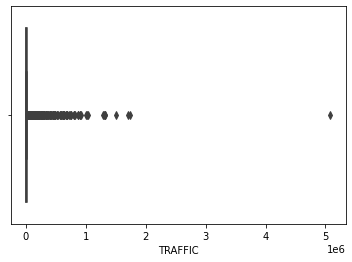

In [72]:
sns.boxplot(MTA_Traffic_per_stat['TRAFFIC']);

Now lets have the dataframe without the outlier, the biggest outlier is 5081493 so i will filter it out

In [73]:
MTA_Traffic_per_stat = MTA_Traffic_per_stat[(MTA_Traffic_per_stat["TRAFFIC"] <   5081493)]
MTA_Traffic_per_stat

,STATION,DATE,TRAFFIC
0,1 AV,06/12/2021,20036.0
1,1 AV,06/13/2021,15884.0
2,1 AV,06/14/2021,20037.0
3,1 AV,06/15/2021,218359.0
4,1 AV,06/16/2021,22383.0
...,...,...,...
37105,ZEREGA AV,09/13/2021,3056.0
37106,ZEREGA AV,09/14/2021,3120.0
37107,ZEREGA AV,09/15/2021,3050.0
37108,ZEREGA AV,09/16/2021,2476.0




---

##Visualizing the data

now lets get to the point and find the insights from this data to help the company.

### Q1: What are the top 5 bussiest stations in Summer 2021 ?

to answer this question, we already have the *MTA_Traffic_per_stat* dataframe that have each station with the traffic for each day. but we want the total summer traffic for each station, so we need to group by the station and sum the traffic.

In [75]:
Top_5 = MTA_Traffic_per_stat.groupby(["STATION"]).agg({'TRAFFIC': sum}).sort_values(by = 'TRAFFIC', ascending = False).head(5)
Top_5

,TRAFFIC
STATION,
34 ST-PENN STA,12084572.0
PATH NEW WTC,8337078.0
34 ST-HERALD SQ,7786214.0
FULTON ST,7718721.0
GRD CNTRL-42 ST,7573961.0


Now, lets plot this ...

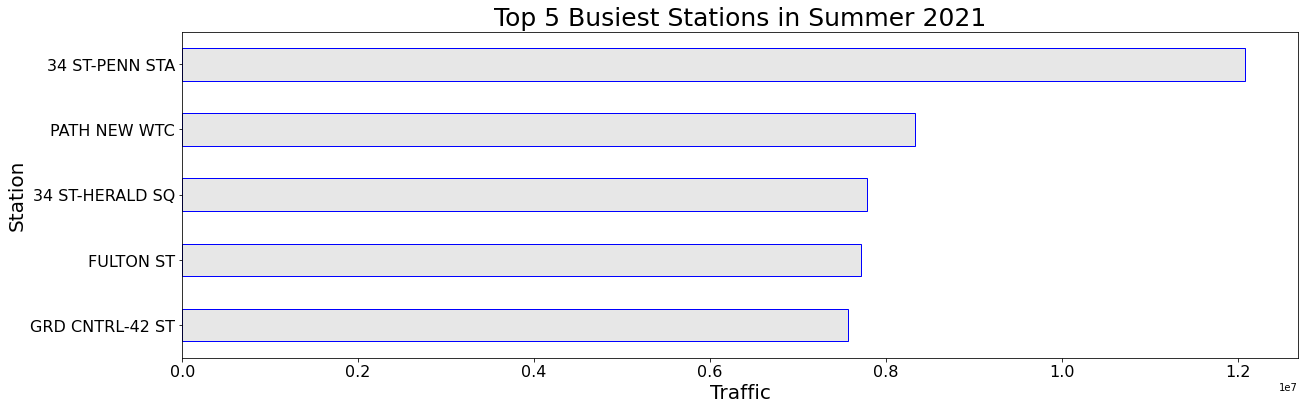

In [76]:
fig, ax = plt.subplots(figsize=(20, 6))
Top_5.sort_values(by = 'TRAFFIC').plot(kind='barh',color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue',ax=ax)

#Changing font sizes 
ax.set_title('Top 5 Busiest Stations in Summer 2021', fontsize=25)
ax.set_xlabel('Traffic', fontsize=20)
ax.set_ylabel('Station', fontsize=20)
plt.rcParams['font.size'] = '10'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(16)
ax.legend().set_visible(False)



### Q2 : On what days of the week are expecting the most traffic ?
Lets first find day names from the DATE and them group by it and calcuating the sum of the total traffic for each day 
 

In [77]:
# lets create a seprate dataframe with only the date and traffic
week_traffic = MTA_Traffic_per_stat[['DATE','TRAFFIC']]

# Now, lets change the DATE to day names 
week_traffic['Day of Week']= pd.to_datetime(week_traffic['DATE']).dt.day_name()
week_traffic.head(2)

,DATE,TRAFFIC,Day of Week
0,06/12/2021,20036.0,Saturday
1,06/13/2021,15884.0,Sunday


In [78]:

weekdays= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',]

# Finally we can group by the day of week and sum the traffic 

week_traffic =week_traffic.groupby(["Day of Week"],as_index=False) ["TRAFFIC"].sum()

# Sort them to make the graph clearer

week_traffic.index = pd.CategoricalIndex(week_traffic["Day of Week"],categories=weekdays,ordered = True )

week_traffic= week_traffic.sort_index().reset_index(drop=True)

week_traffic

,Day of Week,TRAFFIC
0,Monday,62225708.0
1,Tuesday,72210079.0
2,Wednesday,72144590.0
3,Thursday,69200151.0
4,Friday,76612820.0
5,Saturday,52341708.0
6,Sunday,44088047.0


Now we are left with plotting them..

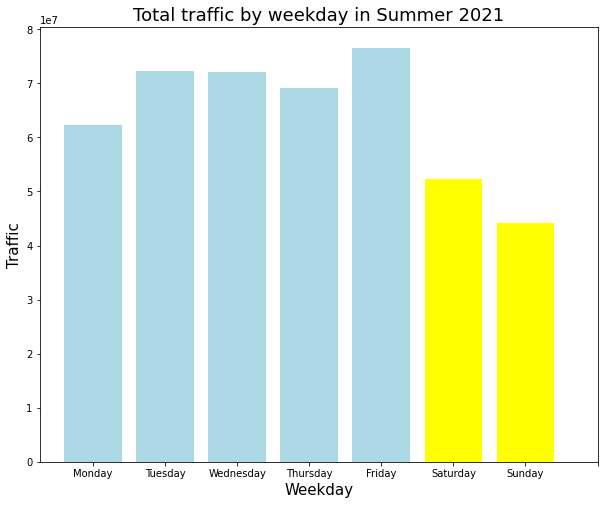

In [79]:
fig, ax = plt.subplots(figsize=(10,8), facecolor='white')
ax.bar(week_traffic['Day of Week'], week_traffic['TRAFFIC'],color = ['lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue','yellow','yellow'])
ax.set_xticks([x for x in range(0,8)])
ax.set_xticklabels(week_traffic['Day of Week']);
ax.set_title('Total traffic by weekday in Summer 2021', fontsize=18)
ax.set_xlabel('Weekday', fontsize=15)
ax.set_ylabel('Traffic', fontsize=15);


In [81]:

week_traffic_linegraph = MTA_Traffic_per_stat[['STATION','DATE','TRAFFIC']]
week_traffic_linegraph['Day of Week']= pd.to_datetime(week_traffic_linegraph['DATE']).dt.day_name()

df_grouped =week_traffic_linegraph.groupby(['STATION',"Day of Week"]) ["TRAFFIC"].sum().reset_index()
top_stations= ['34 ST-PENN STA','PATH NEW WTC','JUNCTION BLVD','34 ST-HERALD SQ',"FULTON ST"]
df_grouped = df_grouped[df_grouped['STATION'].isin(top_stations)]


df_grouped.index = pd.CategoricalIndex(df_grouped["Day of Week"],categories=weekdays,ordered = True )

df_grouped= df_grouped.sort_index().reset_index(drop=True)


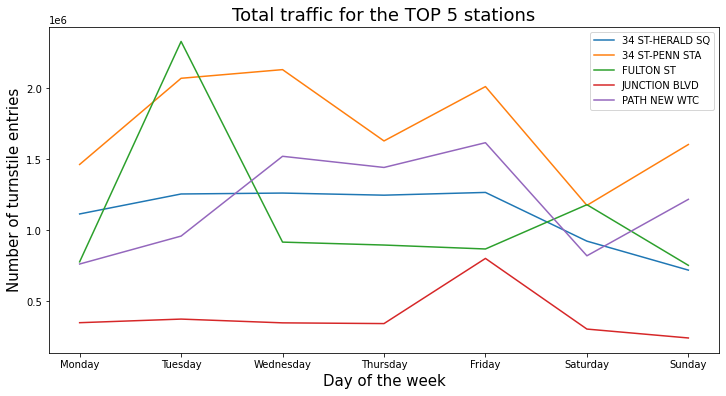

In [82]:
plt.figure(figsize=(12, 6))
legend_list=[]
for i, group in df_grouped.groupby('STATION'):
    plt.plot(group['Day of Week'], group['TRAFFIC'])
    legend_list.append(i)

plt.xlabel('Day of the week', fontsize=15)
plt.ylabel('Number of turnstile entries', fontsize=15)
plt.title('Total traffic for the TOP 5 stations', fontsize=18);
plt.legend(legend_list)

### Q3 : for the Top 5 stations, what are the most busiest Summer weeks?
first lets find a dataframe for each station, then convert the date to week number and sum the traffic. 

In [83]:


# TOP 1 : 134 ST-PENN STA
ST_corona_df = MTA_Traffic_per_stat[(MTA_Traffic_per_stat['STATION']== "34 ST-PENN STA")]
ST_corona_df['Week Number']= pd.to_datetime(ST_corona_df['DATE']).dt.week
ST_corona_df =ST_corona_df.groupby(["Week Number"],as_index=False) ["TRAFFIC"].sum()
ST_corona_df = ST_corona_df.sort_values("Week Number", ascending=False)

# TOP 2 : PATH NEW WTC 
AV = MTA_Traffic_per_stat[(MTA_Traffic_per_stat['STATION']== "PATH NEW WTC")]
AV['Week Number']= pd.to_datetime(AV['DATE']).dt.week
AV =AV.groupby(["Week Number"],as_index=False) ["TRAFFIC"].sum()
AV = AV.sort_values("Week Number", ascending=False)

# TOP 3 : 34 ST-HERALD SQ
ST_7 = MTA_Traffic_per_stat[(MTA_Traffic_per_stat['STATION']== "34 ST-HERALD SQ")]
ST_7['Week Number']= pd.to_datetime(ST_7['DATE']).dt.week
ST_7 =ST_7.groupby(["Week Number"],as_index=False) ["TRAFFIC"].sum()
ST_7 = ST_7.sort_values("Week Number", ascending=False)


# TOP 4 : FULTON ST
CROWN = MTA_Traffic_per_stat[(MTA_Traffic_per_stat['STATION']== "FULTON ST")]
CROWN['Week Number']= pd.to_datetime(CROWN['DATE']).dt.week
CROWN =CROWN.groupby(["Week Number"],as_index=False) ["TRAFFIC"].sum()
CROWN = CROWN.sort_values("Week Number", ascending=False)


# TOP 5 : GRD CNTRL-42 ST
LAFAYETTE = MTA_Traffic_per_stat[(MTA_Traffic_per_stat['STATION']== "GRD CNTRL-42 ST")]
LAFAYETTE['Week Number']= pd.to_datetime(LAFAYETTE['DATE']).dt.week
LAFAYETTE =LAFAYETTE.groupby(["Week Number"],as_index=False) ["TRAFFIC"].sum()
LAFAYETTE = LAFAYETTE.sort_values("Week Number", ascending=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Now, lets combine them in one line graph..

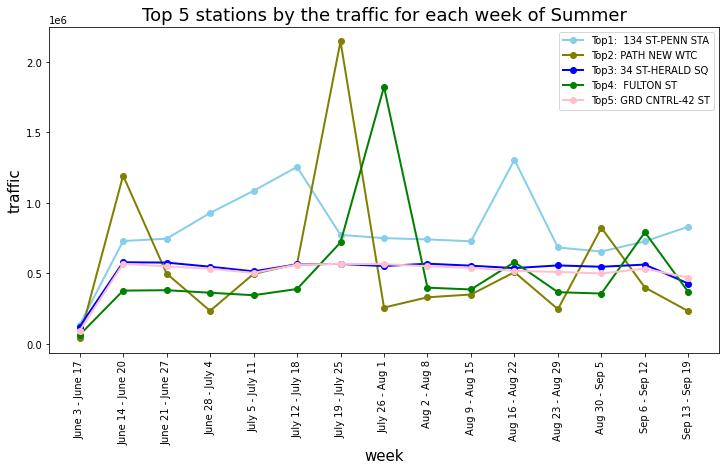

In [84]:
# multiple line plots

plt.figure(figsize=(12, 6))

plt.plot( ST_corona_df['Week Number'], ST_corona_df['TRAFFIC'], marker='o', color='skyblue', linewidth=2,label = 'Top1:  134 ST-PENN STA')

plt.plot( AV['Week Number'], AV['TRAFFIC'],marker='o', color='olive', linewidth=2, label = 'Top2: PATH NEW WTC ')

plt.plot( ST_7['Week Number'], ST_7['TRAFFIC'],marker='o', color='blue', linewidth=2, label = 'Top3: 34 ST-HERALD SQ')

plt.plot( CROWN['Week Number'], CROWN['TRAFFIC'],marker='o', color='green', linewidth=2, label = 'Top4:  FULTON ST')

plt.plot( LAFAYETTE['Week Number'], LAFAYETTE['TRAFFIC'],marker='o', color='pink', linewidth=2, label = "Top5: GRD CNTRL-42 ST")

label =['June 3 - June 17','June 14 - June 20', 'June 21 - June 27', 'June 28 - July 4','July 5 - July 11','July 12 - July 18','July 19 - July 25','July 26 - Aug 1','Aug 2 - Aug 8','Aug 9 - Aug 15','Aug 16 - Aug 22','Aug 23 - Aug 29','Aug 30 - Sep 5','Sep 6 - Sep 12','Sep 13 - Sep 19']

plt.xticks(range(23,38),labels=label, rotation='vertical')

plt.title('Top 5 stations by the traffic for each week of Summer', fontsize=18)

plt.xlabel('week', fontsize=15)

plt.ylabel('traffic', fontsize=15);

plt.legend();

### Q4 : What are the peak hours in the summer ?

lets first combine them into 4 groups ( 4,8,16,20) because the dataset is updated every four hours so to get a clear graph i will filter them separately and then concatenate them

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

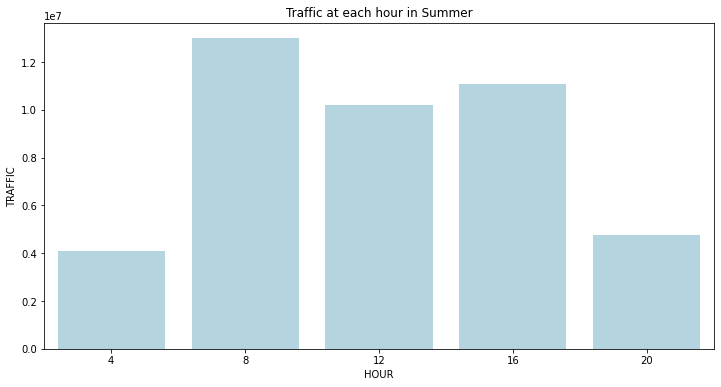

In [85]:
MTA_Traffic_per_hour = MTA_df[MTA_df['STATION'].isin(top_stations)]


MTA_Traffic_per_hour= MTA_Traffic_per_hour.groupby(["TIME"]) ["TRAFFIC"].sum().reset_index()


MTA_Traffic_per_hour['HOUR'] = MTA_Traffic_per_hour['TIME'].apply(lambda x: int(x[:2]))


MTA_Traffic_per_hour_4 = MTA_Traffic_per_hour[(MTA_Traffic_per_hour['HOUR']<=4)]


MTA_Traffic_per_hour_8 = MTA_Traffic_per_hour[(MTA_Traffic_per_hour['HOUR']<=8) & (MTA_Traffic_per_hour['HOUR']>4 )]

MTA_Traffic_per_hour_12 = MTA_Traffic_per_hour[(MTA_Traffic_per_hour['HOUR']<=12) & (MTA_Traffic_per_hour['HOUR']>8 )]

MTA_Traffic_per_hour_16 = MTA_Traffic_per_hour[(MTA_Traffic_per_hour['HOUR']<=16) & (MTA_Traffic_per_hour['HOUR']>12 )]

MTA_Traffic_per_hour_20 = MTA_Traffic_per_hour[(MTA_Traffic_per_hour['HOUR']<=20) & (MTA_Traffic_per_hour['HOUR']>16 )]

MTA_Traffic_per_hour_4['HOUR'] = 4

MTA_Traffic_per_hour_8['HOUR'] = 8

MTA_Traffic_per_hour_12['HOUR'] = 12

MTA_Traffic_per_hour_16['HOUR'] = 16

MTA_Traffic_per_hour_20['HOUR'] = 20

MTA_Traffic_per_hour = pd.concat([MTA_Traffic_per_hour_4,MTA_Traffic_per_hour_8,MTA_Traffic_per_hour_12,MTA_Traffic_per_hour_16,MTA_Traffic_per_hour_20])

MTA_Traffic_per_hour = MTA_Traffic_per_hour.drop('TIME',axis=1)


MTA_Traffic_per_hour= MTA_Traffic_per_hour.groupby(["HOUR"]) ["TRAFFIC"].sum().reset_index()

MTA_Traffic_per_hour= MTA_Traffic_per_hour.sort_values('TRAFFIC',ascending=True)

plt.figure(figsize=(12, 6))

sns.barplot(MTA_Traffic_per_hour['HOUR'],MTA_Traffic_per_hour['TRAFFIC'],palette=['lightblue']).set_title("Traffic at each hour in Summer");


### Q5 : What months of summer are the busiest?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

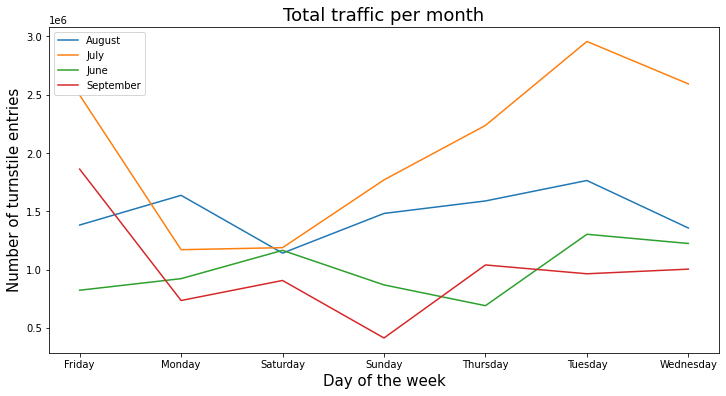

In [86]:
Month_traffic = MTA_Traffic_per_stat[['STATION','DATE','TRAFFIC']]

Month_traffic = Month_traffic[Month_traffic['STATION'].isin(top_stations)]

Month_traffic['DATE'] = pd.to_datetime(Month_traffic['DATE'])
Month_traffic["MONTH"] = Month_traffic['DATE'].dt.month_name()
Month_traffic["WEEKDAY"] = Month_traffic['DATE'].dt.day_name()

Month_traffic =Month_traffic.groupby(["MONTH",'WEEKDAY']) ["TRAFFIC"].sum().reset_index()

plt.figure(figsize=(12, 6))
legend_list=[]
for i, group in Month_traffic.groupby('MONTH'):
    plt.plot(group['WEEKDAY'], group['TRAFFIC'])
    legend_list.append(i)

plt.xlabel('Day of the week', fontsize=15)
plt.ylabel('Number of turnstile entries', fontsize=15)
plt.title('Total traffic per month', fontsize=18);
plt.legend(legend_list);

### Conclusion and recommendation  

Based on the analysis above, choosing the Top 5 stations as the location for the 5 trucks is going to get more customers. 

- So step one : choose these five stations (34 ST-PENN STA , PATH NEW WTC,JUNCTION BLVD,34 ST-HERALD SQ,FULTON ST).
- Foucs on weekdays rather than weekends 
- Best time for opening is 8 AM - 4 PM

